In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('train_spooky.csv')
data.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
data.author.value_counts()


EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [4]:
author = np.array(data.author)
text = np.array(data.text)

In [5]:
def strip(word):
    ans = ''
    for char in word:
        if 'a' <= char.lower() <= 'z':
            ans += char.lower()
    return ans

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(text,author,test_size=0.2)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(15663,) (3916,) (15663,) (3916,)


In [7]:
vocabulary = {}
for line in X_train:
    words = line.split()
    for piece in words:
        word = strip(piece)
        if word in vocabulary:
            vocabulary[word] += 1
        else:
            vocabulary[word] = 1

print(len(vocabulary))

sorted_counts = sorted(vocabulary.items(), key = lambda kv: kv[1], reverse = True)
sorted_vocab = dict(sorted_counts)

final_vocab = []
for i in sorted_vocab.keys():  
    if sorted_vocab[i] > 1:
        final_vocab.append(i)

        
print(len(final_vocab))


23348
14333


In [8]:
sorted_vocab

{'the': 28476,
 'of': 16830,
 'and': 14398,
 'to': 10342,
 'a': 8592,
 'i': 8565,
 'in': 7594,
 'was': 5258,
 'that': 5133,
 'my': 4308,
 'it': 3883,
 'he': 3574,
 'had': 3546,
 'with': 3518,
 'his': 3309,
 'as': 3076,
 'for': 2810,
 'but': 2717,
 'which': 2670,
 'at': 2615,
 'not': 2589,
 'me': 2381,
 'by': 2316,
 'from': 2293,
 'is': 2192,
 'this': 2150,
 'on': 2031,
 'be': 1926,
 'her': 1845,
 'were': 1806,
 'have': 1681,
 'all': 1616,
 'you': 1612,
 'an': 1516,
 'we': 1424,
 'or': 1411,
 'no': 1352,
 'one': 1318,
 'so': 1239,
 'when': 1221,
 'him': 1199,
 'they': 1169,
 'been': 1141,
 'upon': 1119,
 'there': 1067,
 'could': 1050,
 'its': 1029,
 'she': 1028,
 'would': 976,
 'more': 972,
 'now': 946,
 'their': 939,
 'what': 902,
 'some': 867,
 'our': 817,
 'are': 811,
 'into': 773,
 'who': 760,
 'than': 760,
 'very': 747,
 'will': 742,
 'if': 727,
 'them': 708,
 'only': 675,
 'then': 671,
 'up': 645,
 'before': 641,
 'these': 621,
 'about': 612,
 'man': 602,
 'time': 599,
 'any': 594

In [9]:
trainData = np.zeros((X_train.shape[0],len(final_vocab)),'uint16')
for i in range(trainData.shape[0]):
    words = X_train[i].split()
    for j in range(len(words)):
        token = strip(words[j])
        if token in final_vocab:
            trainData[i,final_vocab.index(token)] += 1
        
testData = np.zeros((X_test.shape[0],len(final_vocab)),'uint16')
for i in range(testData.shape[0]):
    words = X_test[i].split()
    for j in range(len(words)):
        token = strip(words[j])
        if token in final_vocab:
            testData[i,final_vocab.index(token)] += 1
        


In [10]:
trainData.shape

(15663, 14333)

In [11]:
trainData

array([[0, 0, 2, ..., 0, 0, 0],
       [4, 1, 1, ..., 0, 0, 0],
       [3, 3, 0, ..., 0, 0, 0],
       ...,
       [3, 1, 0, ..., 0, 0, 0],
       [2, 1, 0, ..., 0, 0, 0],
       [2, 4, 2, ..., 0, 0, 0]], dtype=uint16)

In [12]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial',max_iter=1000)
model.fit(trainData, y_train)


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=0)

In [13]:
#Run model on test data
print(model.score(testData, y_test))

0.8176710929519918


In [14]:
print(model.score(trainData, y_train))

0.9809104258443465


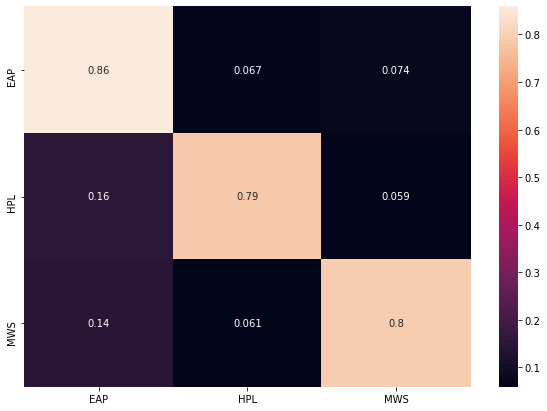

In [15]:
#Visualize performance by Normalized confusion matrix
import seaborn as sn
numClasses = 3
classes = ['EAP','HPL','MWS']

conf = np.zeros([numClasses,numClasses])
guesses = model.predict(testData)

for s in range(testData.shape[0]):
    real = classes.index(y_test[s])
    guess = classes.index(guesses[s])
    conf[real,guess] = conf[real,guess] + 1
 
rowsums = np.sum(conf,1)
rowsums = np.reshape(rowsums,[numClasses,1])
rowsums = np.repeat(rowsums,numClasses, axis = 1)
conf = conf / rowsums
df_cm = pd.DataFrame(conf, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler=StandardScaler()
normtrain = scaler.fit_transform(trainData)
normtest = scaler.transform(testData)

pca = PCA(n_components=500,whiten=True)
lowtrain = pca.fit_transform(normtrain)
lowtest = pca.transform(normtest)

print(lowtrain.shape,lowtest.shape)

(15663, 500) (3916, 500)


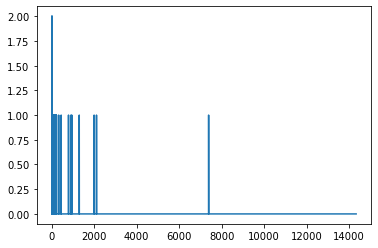

In [28]:
plt.plot(trainData[0,:])

In [29]:
mode2l = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial',max_iter=1000)
model.fit(lowtrain, y_train)
#Run model on test data
print(model.score(lowtest, y_test))

0.8038815117466803


<AxesSubplot:>

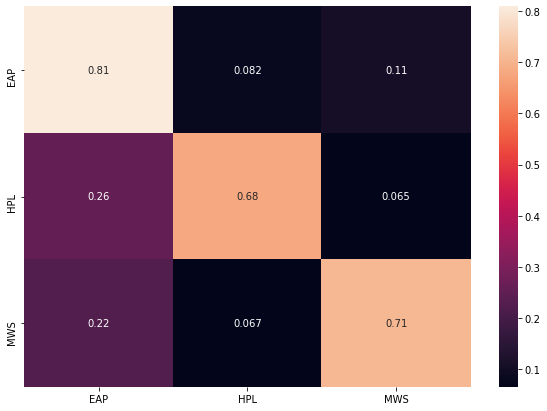

In [24]:
#Visualize performance by Normalized confusion matrix
import seaborn as sn
numClasses = 3
classes = ['EAP','HPL','MWS']

conf = np.zeros([numClasses,numClasses])
guesses = model.predict(lowtest)

for s in range(lowtest.shape[0]):
    real = classes.index(y_test[s])
    guess = classes.index(guesses[s])
    conf[real,guess] = conf[real,guess] + 1
 
rowsums = np.sum(conf,1)
rowsums = np.reshape(rowsums,[numClasses,1])
rowsums = np.repeat(rowsums,numClasses, axis = 1)
conf = conf / rowsums
df_cm = pd.DataFrame(conf, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)